# Collate Data from Raw CP2K Output

This code is designed to take a large amount of raw CP2K output data, and collate it into a single .xyz file which can be used to train a model using the GAP code. 

In [2]:
from ase import io
import nglview as nv
import traceback
from glob import glob
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import quippy as qp
import hashlib

from pprint import pprint

In [3]:
class All_Structures:
    
    def __init__(self):
        self.struct_root = []
        self.all_structs = []
        self.pos_paths = None
        self.frc_paths = None
        self.cell_paths = None
        
        self.pos_search_term = '*pos*.xyz' # Atomic coordinates
        self.frc_search_term = '*frc*.xyz'  # Atomic forces
        self.cell_search_term = '*.cell'  # Cell vectors
        self.ener_search_term = '*.ener'  # Energies/Temperatures for MD
        self.xyz_search_term = '*structure_properties_collated.xyz' # Specific search term for collated xyz data
        
    def add_struct_root_dir(self, pathname):
        self.struct_root.append(pathname)
        
    def get_files(self, search_term):
        paths = []
                
        for each_path in self.struct_root:
            new_paths = [y for x in os.walk(each_path) for y in glob(os.path.join(x[0], search_term))]
            paths.extend(new_paths)

        return paths
    
    def check_paths(self, struct_pos, frc_fn, cell_fn, ener_fn_final=None):
        path_good = True
        
        # Check on paths
        if ener_fn_final is not None:
            if os.path.dirname(struct_pos) != os.path.dirname(ener_fn_final):
                print("Error matching atomic coordinates and energy file paths:")
                print("Atomic coordinates at: " + str(struct_pos))
                print("Energy file at: " + str(ener_fn_final))
                path_good = False

        if os.path.dirname(struct_pos) != os.path.dirname(frc_fn):
            print("Error matching atomic coordinates and force file paths:")
            print("Atomic coordinates at: " + str(struct_pos))
            print("Force file at: " + str(frc_fn))
            path_good = False
            
        if os.path.dirname(struct_pos) != os.path.dirname(cell_fn):
            print("Error matching atomic coordinates and cell file paths:")
            print("Atomic coordinates at: " + str(struct_pos))
            print("Cell file at: " + str(cell_fn))
            path_good = False
            
        return path_good
    
    def open_all_xyz_structures(self):
        self.pos_xyz_list = self.get_files(self.xyz_search_term)
        
        for struct_counter, struct_pos in enumerate(self.pos_xyz_list):
            struct = io.read(struct_pos, index=':')
            self.all_structs.append(struct)
    
    def open_all_cp2k_structures(self, write=False):
        self.pos_xyz_list = self.get_files(self.pos_search_term)
        self.frc_xyz_list = self.get_files(self.frc_search_term)
        self.cell_list = self.get_files(self.cell_search_term)
        self.ener_list = self.get_files(self.ener_search_term)
                
        # Print some diagnostic info
        print("Collecting data for %i total structures" % len(self.pos_xyz_list))
        
        for struct_counter, struct_pos in enumerate(self.pos_xyz_list):
            struct = io.read(struct_pos, index=':')
            
            aimd_struct_counter = 0  # Separate counter over AIMD sims as they have different output files
            try:
                # Extract important information from cp2k input/output files 
                struct_frc = [io.read(frc_fn, index=':')
                              for frc_fn in self.frc_xyz_list if 
                              os.path.dirname(struct_pos) + "/" in frc_fn][0]
                
                struct_frc_fn_final = [frc_fn
                                       for frc_fn in self.frc_xyz_list if 
                                       os.path.dirname(struct_pos) + "/" in frc_fn][0]
                
                cell = [np.genfromtxt(cell_fn)[:,1:]
                        for cell_fn in self.cell_list if 
                        os.path.dirname(struct_pos) + "/" in cell_fn][0]
                
                cell_fn_final = [cell_fn
                                 for cell_fn in self.cell_list if 
                                 os.path.dirname(struct_pos) + "/" in cell_fn][0]
                                
                if "aimd" in struct_pos.lower():
                    ener = [np.genfromtxt(ener_fn) for ener_fn in self.ener_list if 
                            os.path.dirname(struct_pos) + "/" in ener_fn][0]
                    
                    ener_fn_final = [ener_fn for ener_fn in self.ener_list if 
                            os.path.dirname(struct_pos) + "/" in ener_fn][0]
                
                # Check on if all the pathways make sense
                if "aimd" in struct_pos.lower():
                    if not self.check_paths(struct_pos, 
                                            struct_frc_fn_final, 
                                            cell_fn_final,
                                            ener_fn_final=ener_fn_final):
                        print("Error")
                        break
                else:
                    if not self.check_paths(struct_pos, 
                                            struct_frc_fn_final, 
                                            cell_fn_final):
                        print("Error")
                        break
                
                # Loop over each frame and attach important info to the ase.Atoms object
                for frame_counter, frame in enumerate(struct):
                    frame.pbc = True
                    frame.cell = cell
                    frame.forces = struct_frc[frame_counter].positions.copy()
                    frame.energy = struct_frc[frame_counter].info['E'] * 27.211396641308  # Conversion from Ha to eV
                    frame.info['energy'] = frame.energy
                    frame.info['root_path'] = os.path.dirname(self.pos_xyz_list[struct_counter])
                    frame.info['stoichiometry'] = os.path.dirname(self.pos_xyz_list[struct_counter]).split('/')[-1]
                    frame.info['nominal_density'] = os.path.dirname(self.pos_xyz_list[struct_counter]).split('/')[-2]
                    
                    # Give the frame a unique ID based on the forces, positions and energy...
                    hash_string = np.array2string(np.vstack((frame.positions, frame.forces))) + str(frame.energy)
                    frame.info['md5_hash'] = hashlib.md5(hash_string.encode('utf-8')).hexdigest()
                    
                    if write:
                        # Not used for anything - part of a stupid hack to get the forces to print
                        calc = qp.potential.Potential("IP Tersoff", param_str = "")

                        # This is a stupid hack we have to do to print out the forces properly
                        frame.calc = calc
                        frame.calc.results['forces'] = frame.forces
                    
                    # Remove some duplicate information
                    del frame.info['E']
                    
                    if 'i' in frame.info.keys():
                        frame.info['md_step'] = frame.info['i']
                        del frame.info['i']
                    
                    if "aimd" in struct_pos.lower():
                        frame.info['temp'] = ener[frame_counter][3]
                        frame.info['energy_kinetic'] = ener[frame_counter][2] * 27.211396641308  # Conversion from Ry to eV
                        frame.info['energy_potential'] = ener[frame_counter][4] * 27.211396641308  # Conversion from Ry to eV
                    else:
                        frame.info['temp'] = 0.0
                    
                    frame.wrap()              
                    
                del struct_frc
                del cell
                
                if "aimd" in struct_pos.lower():
                    del ener
                
                aimd_struct_counter += 1
            except:
                print("Unable to read forces for structure at %s" % (struct_pos))
                print(traceback.format_exc())
                print("")
            
            if write:
                io.write(os.path.join(os.path.dirname(struct_pos), "structure_properties_collated.xyz"), struct, format='extxyz')
            else:
                self.all_structs.append(struct)

In [4]:
# NOTE
# NOT USED AT THE MOMENT. eventually want to set config type sigmas individually based on the binding energy...
# Got to think of something to do with the forces as well....

class Structure_Analyser:
    
    def __init__(self, str_obj):
        # Definitions
        self.str_obj = str_obj
        self.fig_counter = 0
        self.max_num_colours = 10
        
        # Reference states
        self.c_ref = None
        self.h_ref = None
        self.o_ref = None
        
        self.root_dir = '/Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/2_Iter1_CP2K_Reference_Optimisation'
        
        self.ref_state_structures = all_structs.All_Structures()
        self.ref_state_structures.add_struct_root_dir(self.root_dir)
        self.ref_state_structures.open_all_cp2k_structures()
        self.set_reference_states()

    def set_reference_states(self):
        """Set the binding energy reference states"""
        
        for traj in self.ref_state_structures.all_structs:
            print(traj[0].get_chemical_formula(mode='hill'))
            if traj[0].get_chemical_formula(mode='hill') == "O2":
                print(traj[0])
                self.o_ref = traj[-1]
            elif traj[0].get_chemical_formula(mode='hill') == "H2":
                print(traj[0])
                self.h_ref = traj[-1]
            elif traj[0].get_chemical_formula(mode='hill') == "C72":
                print(traj[0])
                self.c_ref = traj[-1]
            
    def compute_cho_formation_energy(self, struct, c_ref, h_ref, o_ref):
    
        e_c = c_ref.energy / len(c_ref)
        e_h = h_ref.energy / len(h_ref)
        e_o = o_ref.energy / len(o_ref)

        n_c = self.get_num_element(struct, 'C')
        n_h = self.get_num_element(struct, 'H')
        n_o = self.get_num_element(struct, 'O')
    
        formation_energy = struct.energy - (n_c * e_c + n_h * e_h + n_o * e_o)

        return formation_energy   


In [5]:
class Structure_Collator:
    
    def __init__(self, str_obj):
        self.str_obj = str_obj
        
        self.all_frames_unsorted = None
        
        # Categories and config_types MUST all be lowercase
        # even if the actual paths have caps. Or they will be ignored.
        # Categories for sorting will be automatically determined from
        # The paths of the files. Files which cannot be categorised will
        # Be ignored
        self.categories = ['aimd',
                           'optimisation',
                           'surf',
                           'clust',
                           'reference',
                           'bulk',
                           'iter1',
                           'iter2',
                           'iter3',
                           'iter4',
                           'iter5',
                           'iter6',
                           'iter7',
                           'iter8',
                           'iter9',
                           'iter10',
                           'rss',
                           'over500',
                           'under500',
                           'md',
                           'gap_20',
                           'gap-20',
                           'graphite_layer_sep']
        
        self.cat1 = ['iter1',
                     'iter2',
                     'iter3',
                     'iter4',
                     'iter5',
                     'iter6',
                     'iter7',
                     'iter8',
                     'iter9',
                     'iter10']
        
        self.cat2 = ['aimd',
                     'optimisation',
                     'rss',
                     'md',
                     'gap-20',
                     'graphite_layer_sep']
        self.cat3 = ['surf',
                     'clust',
                     'bulk',
                     'reference',
                     'gap_20']
        
        # These shouldn't have any overlap...
        # Although Sigmas will be determined automatically, we can force
        # Our own values under certain conditions.
        self.manual_sigmas = {'over500':'0.1:0.05:0.0:0.0',
                              'under500':'0.01:0.01:0.0:0.0',
                              'optimisation':'0.005:0.001:0.0:0.0',
                              'reference':'0.001:0.001:0.0:0.0'}
        
        self.sigmas_string = None
        
        # From hottest to coldest
        # This can be a list of numbers, temperatures will be determined
        # From CP2K output files and sorted accordingly.
        # Can be ignored, implicitly done by auto-sigmas selection.
        self.temperatures = [500,1000,2000]
        
        # Number of temp labels must be len(self.temperatures) + 1
        self.temperature_labels = ['t_label_1',
                                   't_label_2',
                                   't_label_3',
                                   't_label_4']
        
        self.cw_root_dir = '/path/to/training/data/repository'
        
        self.categorised_frames_indices = {}
        self.categorised_frames = {}
        self.indices = {}
        self.all_config_types = []
        self.config_type_sigmas = {}
        
        for key in self.categories:
            self.indices[key] = []
        
        self.md_save_every = 200
        self.md_skip_first = 20
        
        self.surf_md_skip_first = 0
        self.clust_md_skip_first = 0
    
    def collate_all_data(self, write=False):
        if write:
            if not os.path.exists(self.cw_root_dir):
                os.mkdir(self.cw_root_dir)
        
        for i, cat1 in enumerate(self.cat1):
            
            if write:
                pathname1 = os.path.join(self.cw_root_dir, str(cat1))
                if not os.path.exists(pathname1):
                    os.mkdir(pathname1)
            
            self.categorised_frames[cat1] = {}
            self.categorised_frames_indices[cat1] = {}
            
            for j, cat2 in enumerate(self.cat2):
                
                if write:
                    pathname2 = os.path.join(pathname1, str(cat2))
                    if not os.path.exists(pathname2):
                        os.mkdir(pathname2)
                
                self.categorised_frames[cat1][cat2]  = {}
                self.categorised_frames_indices[cat1][cat2] = {}
                
                for k, cat3 in enumerate(self.cat3):
                    
                    if write:
                        pathname3 = os.path.join(pathname2, str(cat3))
                        if not os.path.exists(pathname3):
                            os.mkdir(pathname3)
                    
                    if cat2 == 'aimd':
                        
                        self.categorised_frames[cat1][cat2][cat3] = {}
                        self.categorised_frames_indices[cat1][cat2][cat3] = {}
                        
                        for l, cat4 in enumerate(self.temperature_labels):
                            
                            if write:
                                pathname4 = os.path.join(pathname3, str(cat4))
                                if not os.path.exists(pathname4):
                                    os.mkdir(pathname4)
                            
                            config_type = str(cat1) + '-' + str(cat2) + '-' + str(cat3) + '-' + str(cat4)
                                        
                            self.all_config_types.append(config_type)
                            overlap_list = self.get_list_overlap(self.indices[cat1],
                                                                 self.indices[cat2])
                            overlap_list = self.get_list_overlap(overlap_list,
                                                                 self.indices[cat3])
                            overlap_list = self.get_list_overlap(overlap_list,
                                                                 self.indices[cat4])
                            
                            self.categorised_frames_indices[cat1][cat2][cat3][cat4] = overlap_list
                            self.categorised_frames[cat1][cat2][cat3][cat4] = \
                            [frame for i, frame in enumerate(self.all_frames_unsorted) if i in overlap_list]
                            
                            for frame in self.categorised_frames[cat1][cat2][cat3][cat4]:
                                frame.info['config_type'] = config_type
                            
                            if write:
                                io.write(os.path.join(pathname4, config_type+'.xyz'),
                                        self.categorised_frames[cat1][cat2][cat3][cat4],
                                        format='extxyz')
                    else:
                        config_type = str(cat1) + '-' + str(cat2) + '-' + str(cat3)
                        
                        self.all_config_types.append(config_type)
                        
                        overlap_list = self.get_list_overlap(self.indices[cat1],
                                                             self.indices[cat2])
                        overlap_list = self.get_list_overlap(overlap_list,
                                                             self.indices[cat3])
                        
                        self.categorised_frames_indices[cat1][cat2][cat3] = overlap_list
                        self.categorised_frames[cat1][cat2][cat3] = \
                        [frame for i, frame in enumerate(self.all_frames_unsorted) if i in overlap_list]
                                         
                        for frame in self.categorised_frames[cat1][cat2][cat3]:
                                frame.info['config_type'] = config_type
                        
                        if write:
                                io.write(os.path.join(pathname3, config_type+'.xyz'), 
                                         self.categorised_frames[cat1][cat2][cat3], 
                                         format='extxyz')
                                
    def print_manual_config_type_sigmas(self):
        """Print a command line argument for the config_type sigmas based on the manual settings"""
        
        self.sigmas_string = 'config_type_sigma={'
        
        for config_type in self.all_config_types:
            for key, value in self.manual_sigmas.items():
                if key in config_type:
                    self.sigmas_string += config_type + ':' + value + ':'
                    
        # Remove the final colon
        self.sigmas_string = self.sigmas_string[:-1]
        self.sigmas_string += '}'
                    
        print(self.sigmas_string)
                                    
    def collate_all_frames_unsorted(self):
        self.all_frames_unsorted = []
        
        # Return this as a generator so it doesn't clog memory and crash...
        # self.all_frames_unsorted = (i for s in (frame for frame in (traj for traj in self.str_obj.all_structs)) for i in s)
        # self.all_frames_unsorted = [i for s in [frame for frame in [traj for traj in self.str_obj.all_structs]] for i in s]
        for traj in self.str_obj.all_structs:
            traj_cut = self.slice_trajectory(traj)
            self.all_frames_unsorted.extend(traj_cut)            
    
    def build_index_lists(self):
        for i, frame in enumerate(self.all_frames_unsorted):
            path_lowercase = frame.info['root_path'].lower()
            
            # Temporary debugging
            if "isolated" in path_lowercase:
                print(path_lowercase)
                
            for key in self.indices.keys():
                if key in path_lowercase:
                    self.indices[key].append(i)
                elif 'aimd' in path_lowercase:
                    try:
                        if frame.info['temp_range'] == key:
                            self.indices[key].append(i)
                    except:
                        print(i)
                        print(path_lowercase)
                        break
                        
    def get_list_overlap(self, list1, list2):
        return list(set(list1).intersection(list2))
    
    def assign_temperature_descriptors(self):
        for traj in self.str_obj.all_structs:
            if 'aimd' in traj[0].info['root_path'].lower():
                self.split_by_temperature(traj)
    
    def get_all_temperatures(self, traj):
        return np.array([t.info['temp'] for t in traj])
    
    def split_by_temperature(self, traj, do_return=False):
        all_temps = self.get_all_temperatures(traj)
        all_inx = range(len(traj))
        
        traj_inx_split_temp = []
        
        # Set up conditions
        conditions = [all_temps > max(self.temperatures)]
        for i in range(len(self.temperatures) - 1):
            conditions.append((all_temps <= self.temperatures[i]) & (all_temps > self.temperatures[i + 1]))
        conditions.append(all_temps <= min(self.temperatures))
        
        for condition in conditions:
            traj_inx_split_temp.append(np.extract(condition, all_inx))
            
        for i, split in enumerate(traj_inx_split_temp):
            for s in split:
                traj[s].info['temp_range'] = self.temperature_labels[i]
        
        if do_return:
            return traj_inx_split_temp, all_temps, all_inx
        
    def slice_trajectory(self, traj):
        
        if 'aimd' in traj[0].info['root_path'].lower():
            if 'surf' in traj[0].info['root_path'].lower():
                traj_cut = traj[self.surf_md_skip_first::self.md_save_every]
            elif 'clust' not in traj[0].info['root_path'].lower():
                traj_cut = traj[self.clust_md_skip_first::self.md_save_every]
            else:
                traj_cut = traj[self.md_skip_first::self.md_save_every]
        else:
            traj_cut = [traj[-1]]
        
        return traj_cut
        

In [6]:
def setup_matplotlib_environment():
    # If I decide to generate n colours using a built in colourmap instead.
    # self.colour_generator = color=cm.rainbow(np.linspace(0,1,self.max_num_colours))

    plt.rc('lines', linewidth=4)
    # plt.rc('axes', prop_cycle=(plt.cycler('linestyle', ['-', '--', ':', '-.'])))

    # Font
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = 18
    plt.rcParams['legend.fontsize'] = 18

    # Ticks
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.major.size'] = 5.0
    plt.rcParams['xtick.minor.size'] = 3.0
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0

    # Line width
    plt.rcParams['xtick.major.width'] = 3.0
    plt.rcParams['xtick.minor.width'] = 3.0
    plt.rcParams['ytick.major.width'] = 3.0
    plt.rcParams['ytick.minor.width'] = 3.0
    plt.rcParams['axes.linewidth'] = 3.0

    # Marker Size
    plt.rcParams['lines.markersize'] = 10

    # Legend
    plt.rcParams['legend.handlelength'] = 3.0

In [7]:
class Split_Training_Validation():
    
    def __init__(self):
        self.all_structs = []
        self.struct_root = []
        self.mandatory_file_paths = []
        self.xyz_search_term = "*.xyz"
        
        self.mandatory_config_keys = []
        
        self.num_training = 300
        self.output_dir = None
        
        self.training_structs = []
        self.validation_structs = []
        
        # These shouldn't have any overlap...
        self.manual_sigmas = {'over5000':'0.1:0.05:0.0:0.0',
                              'under500':'0.01:0.01:0.0:0.0',
                              'optimisation':'0.005:0.001:0.0:0.0',
                              'reference':'0.001:0.001:0.0:0.0'}
        
        self.all_config_types = []
        self.config_type_sigmas = {}
        
        self.mandatory_paths = None
        self.mandatory_ids = None
    
    def add_struct_root_dir(self, pathname):
        self.struct_root.append(pathname)
        
    def add_mandatory_file_path(self, pathname):
        self.mandatory_file_paths.append(pathname)
        
    def read_mandatory_file_paths(self):
        paths = []
        unique_ids = []
        
        for each_file in self.mandatory_file_paths:
            data = np.genfromtxt(each_file, dtype=str)
            paths.extend(data[:,0])
            unique_ids.extend(data[:,1])
            
        self.mandatory_paths = paths
        self.mandatory_ids = unique_ids
        
    def get_files(self, search_term):
        paths = []
                
        for each_path in self.struct_root:
            new_paths = [y for x in os.walk(each_path) for y in glob(os.path.join(x[0], search_term))]
            paths.extend(new_paths)

        return paths
    
    def open_all_xyz_structures(self):
        self.pos_xyz_list = self.get_files(self.xyz_search_term)
        
        for struct_counter, struct_pos in enumerate(self.pos_xyz_list):
            struct = io.read(struct_pos, index=':')
            self.all_structs.extend(struct)
        
        self.get_all_config_types()
            
    def get_all_config_types(self):
        
        for frame in self.all_structs:
            try:
                if frame.info['config_type'] not in self.all_config_types:
                    self.all_config_types.append(frame.info['config_type'])
            except:
                print("Frame has no config type set...")
                
    def get_element_abundancies(self):
        counts = {}
        
        for frame in self.all_structs:
            elements_all = [at.symbol for at in frame]
            unique_elements = set(elements_all)
            
            for elem in unique_elements:
                try:
                    counts[elem] += elements_all.count(elem)
                except KeyError:
                    counts[elem] = 0
                    
        total_at_count = 0
        for elem, elem_count in counts.items():
            total_at_count += elem_count
        
        for elem, elem_count in counts.items():
            counts[elem] /= total_at_count
        
        self.element_abundancies = counts
        
    def set_config_type_sigmas(self, config_type_sigmas):
        """Sets sigmas for specific config types AS element-wise sigmas
        so that they take precedent over the force-based-atom-all-sigmas.
        
        you therefore need to call this function AFTER
        calling set_force_based_all_atom_sigmas()"""
        
        for frame in self.all_structs:
            if frame.info['config_type'] in config_type_sigmas.keys():
                sigmas = config_type_sigmas[frame.info['config_type']]
                s_e, s_f = sigmas[0], sigmas[1]
                
                sigmas_frame = np.ones((len(frame), 3)) * s_f
                
                frame.info['energy_sigma'] = s_e
                frame.arrays['force_component_sigma'] = sigmas_frame
            
    def set_force_based_all_atom_sigmas(self, min_f_sig, f_scaling_fac, e_min_sigma, 
                                        e_scaling_fac=10, max_force=50, alpha=0.01, method='alpha-log',
                                        large_force_correction=False, max_sigma=50, sigma_onset=50):
        
        """A whole set of different (mostly experimental) ways of determining the sigmas
        automatically on an element-wise basis.
        
        It's highly recommended to use alpha-log."""
        
        self.get_element_abundancies()
        
        self.maf_3d_all = []
        self.var_3d_all = []
        self.maf_all = []
        self.var_all = []
        
        for frame in self.all_structs:
            
            # Get the relevant information on the frame
            ########
            forces = frame.get_forces()
            elements = [at.symbol for at in frame]
            
            # For surfaces etc, force behaviour in each direction might be different.
            maf_3d = np.mean(np.absolute(forces), axis=0)
            var_3d = np.var(forces, axis=0)
            
            # Global MAF for the frame
            maf = np.mean(maf_3d)
            var = np.var(forces)
            
            # Assign to object variables
            self.maf_3d_all.append(maf_3d)
            self.var_3d_all.append(var_3d)
            self.maf_all.append(maf)
            self.var_all.append(var)
            ########
            
            
            if method == 'linear_nonsense':
                # Old method
                # Actually compute the errors
                element_scaling = [self.element_abundancies[elem] for elem in elements] * 3
                element_scaling = np.array(element_scaling).reshape(len(frame), 3)
                sigmas_frame = np.absolute(forces) * force_scaling_factor  # Multiply each force element by a constant scaling factor
                sigmas_frame = np.multiply(sigmas_frame, element_scaling)  # Multiply each row by the abundance of the element
                sigmas_frame += min_f_sig  # Add the minimum force sigma 
            
            elif method == 'linear':
                # Not using element scaling atm
                element_scaling = [self.element_abundancies[elem] for elem in elements] * 3
                element_scaling = np.array(element_scaling).reshape(len(frame), 3)
                
                sigmas_frame = force_scaling_factor * (np.absolute(forces) + maf)
                sigmas_frame += min_f_sig  # Add the minimum force sigma 
                
            elif method == 'fixed':
                sigmas_frame = forces * 0
                sigmas_frame += force_scaling_factor
            
            elif method == 'tanh':
                # Not using element scaling atm
                element_scaling = [self.element_abundancies[elem] for elem in elements] * 3
                element_scaling = np.array(element_scaling).reshape(len(frame), 3)

                gamma = 2 - np.tanh(np.absolute(forces) / max_force) - np.tanh(maf / max_force)
                sigmas_frame = np.power(np.absolute(forces), gamma)
                sigmas_frame += np.power(maf, gamma)
                sigmas_frame += np.absolute(forces) * np.sqrt(maf)
                sigmas_frame *= f_scaling_fac
                sigmas_frame += min_f_sig
                
            elif method == 'log':
                # Not using element scaling atm
                element_scaling = [self.element_abundancies[elem] for elem in elements] * 3
                element_scaling = np.array(element_scaling).reshape(len(frame), 3)
                
                sigmas_frame = np.log((1 + np.absolute(forces)) * (1 + maf))
                sigmas_frame *= f_scaling_factor
                sigmas_frame += min_f_sig
                
            elif method == 'alpha_log':
                # Not using element scaling atm
                element_scaling = [self.element_abundancies[elem] for elem in elements] * 3
                element_scaling = np.array(element_scaling).reshape(len(frame), 3)
                
                sigmas_frame = np.log(1 + alpha * np.absolute(forces) + alpha * maf)
                sigmas_frame = (f_scaling_factor / alpha) * sigmas_frame
                sigmas_frame += min_f_sig
              
    
            if large_force_correction:
                correction = sigma_max * (1 - np.tanh(sigma_onset /(np.absolute(forces) + maf)))
                sigmas_frame += correction
    
            # Compute energy scaling factor.
            # e_sigma = np.mean(np.absolute(sigmas_frame)) * e_scaling_fac
            
            e_sigma = e_min_sigma + np.power(np.mean(sigmas_frame), 2)
            
            frame.info['energy_sigma'] = e_sigma
            frame.arrays['force_component_sigma'] = sigmas_frame
            
    
    def set_manual_config_type_sigmas(self):
        """DEPRECATED"""
        
        for config_type in self.all_config_types:
            for key, value in self.manual_sigmas.items():
                if key in config_type:
                    self.config_type_sigmas[config_type] = value.replace(":", " ") 
                    
        for frame in self.all_structs:
            config_type = frame.info['config_type']
            frame.info['energy_sigma'] = self.config_type_sigmas[config_type].split(" ")[0]
            frame.info['force_sigma'] = self.config_type_sigmas[config_type].split(" ")[1]
            
        
    def split_training_validation(self):
        training_probability = self.num_training / len(self.all_structs)
        
        for frame in self.all_structs:
            is_included = False
            
            if any([key in frame.info['config_type'] for key in self.mandatory_config_keys]):
                # Exception to the rule for configurations which are considered 'mandatory'
                
                print("Config of type: %s included as mandatory" % frame.info['config_type'])
                print("Path of mandatory configuration: %s" % frame.info['root_path'])
                self.training_structs.append(frame)
                is_included = True
            elif self.mandatory_paths is not None:
                if frame.info['root_path'] in self.mandatory_paths:
                    if str(frame.info['md_step']) in self.mandatory_ids:
                        print("Frame Mandatory From File: %s" % frame.info['root_path'])
                        self.training_structs.append(frame)
                        is_included = True
                        
            if (np.random.rand() < training_probability) and (is_included == False):
                self.training_structs.append(frame)
            elif is_included == False:
                self.validation_structs.append(frame)
                
    def write_training_validation(self):
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)

        io.write(os.path.join(self.output_dir, "training.xyz"), self.training_structs, format='extxyz')
        io.write(os.path.join(self.output_dir, "validation.xyz"), self.validation_structs, format='extxyz')
    

In [11]:
struct_roots = ['/path/to/repo_1',
                '/path/to/repo_2',
                '/path/to/repo_3',
                '/path/to/repo_4']

In [10]:
# This code here for collating data from CP2K Source into .xyz format
# Takes some time to perform all the conversions.

structures = All_Structures()
[structures.add_struct_root_dir(struct_root) for struct_root in struct_roots]
structures.open_all_cp2k_structures(write=True)

In [12]:
# This code here to just read in the already collated INDIVIDUAL .xyz files.

structures = All_Structures()
[structures.add_struct_root_dir(struct_root) for struct_root in struct_roots]
structures.open_all_xyz_structures()

In [13]:
print(len(structures.all_structs))

3489


In [13]:
print(len(structures.all_structs))

4044


In [14]:
collator = Structure_Collator(structures)
collator.assign_temperature_descriptors()
collator.collate_all_frames_unsorted()
collator.build_index_lists()

# Make sure to set write=True if adding new structures!!
collator.collate_all_data(write=True)

# collator.print_manual_config_type_sigmas()

/users/patrickrowe/documents/research/cho_gap/2_training_data/2_iter1_cp2k_reference_optimisation/5_isolated_atoms/o
/users/patrickrowe/documents/research/cho_gap/2_training_data/2_iter1_cp2k_reference_optimisation/5_isolated_atoms/h
/users/patrickrowe/documents/research/cho_gap/2_training_data/2_iter1_cp2k_reference_optimisation/5_isolated_atoms/c


/Users/patrickrowe/anaconda3/lib/python3.8/site-packages/ase/io/extxyz.py:997: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [15]:
print(len(collator.all_frames_unsorted))

4693


In [15]:
print(len(collator.all_frames_unsorted))

5248


In [16]:
# Include the 'active learning' mandatory paths
mandatory_path_files = ['/Users/patrickrowe/Documents/Research/CHO_GAP/5_Testing/2_Carbon_Testing_Framework/plotting/1_Force_Errors/011_Atom_Sigmas_Method_log_C_0.001/011_Atom_Sigmas_Method_log_C_0.001_Largest_Force_Errors.txt',
                        '/Users/patrickrowe/Documents/Research/CHO_GAP/5_Testing/2_Carbon_Testing_Framework/plotting/1_Force_Errors/033_Iter2_Atom_Sigmas_Method_alpha_log_C_0.0005_Alpha_0.01/033_Iter2_Atom_Sigmas_Method_alpha_log_C_0.0005_Alpha_0.01_Largest_Force_Errors.txt']

In [17]:
np.random.seed(0)

method = 'alpha_log'  # Which method to use? tanh, linear or log

max_force = 50  # Tanh method only, value to divide forces by in the exponent
energy_min_sigma = 0.01  # Minimum value for energy sigma 
alpha = 0.01

# if using large force correction/punishment
large_force_correction = False
max_sigma = 50
sigma_onset = 50

min_force_sigma = 0.01  # Minimum value for force sigma

### THIS IS WHAT YOU WANT TO CHANGE.
force_scaling_factor = 5e-5  # value of C, by which to scale the sigmas
###################################

config_type_sigmas = {'iter1-optimisation-reference': [0.005, 0.01],
                      'iter6-graphite_layer_sep-gap_20': [0.005, 0.01]}

# prep functions
splitter = Split_Training_Validation()

# Add the source directory for files...
splitter.add_struct_root_dir('/Users/patrickrowe/Documents/Research/CHO_GAP/6_Collated_Training_Data/')

# For 'active learning' include mandatory files by individual path
[splitter.add_mandatory_file_path(mand_file) for mand_file in mandatory_path_files]
splitter.read_mandatory_file_paths()

# Set mandatory config types
splitter.mandatory_config_keys = ["reference", "iter2", "iter3", "iter4", "iter5", "iter6", "iter7", "iter8", "iter9", "iter10"]

splitter.open_all_xyz_structures()
#splitter.set_manual_config_type_sigmas()
splitter.set_force_based_all_atom_sigmas(min_force_sigma, force_scaling_factor, energy_min_sigma)
splitter.set_config_type_sigmas(config_type_sigmas)

In [18]:
# Actual splitting and writing
output_dir = '/path/to/output/directory'
filename = 'dataset_name'
output_dir = os.path.join(output_dir, filename)

splitter.split_training_validation() # to write...
splitter.output_dir = output_dir
splitter.write_training_validation() # to write...

with open(os.path.join(output_dir, "info.txt"), 'w') as f:
    f.write("method = {}\n".format(method))
    f.write("max_force = {}\n".format(max_force))
    f.write("min_force_sigma = {}\n".format(min_force_sigma))
    f.write("force_scaling_factor = {}\n".format(force_scaling_factor))
    f.write("energy_min_sigma = {}\n".format(energy_min_sigma))
    

Config of type: iter2-rss-clust included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/3_Iter2_GAP_011_RSS/clust_structs/C36O6
Config of type: iter2-rss-clust included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/3_Iter2_GAP_011_RSS/clust_structs/C6H6
Config of type: iter2-rss-clust included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/3_Iter2_GAP_011_RSS/clust_structs/C12O6H6
Config of type: iter2-rss-clust included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/3_Iter2_GAP_011_RSS/clust_structs/C54H6
Config of type: iter2-rss-clust included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/3_Iter2_GAP_011_RSS/clust_structs/C30
Config of type: iter2-rss-clust included as mandatory
Pa

Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/330
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/102
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/592
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/69
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/901
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patric

Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/486
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/882
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/278
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/876
Config of type: iter6-gap-20-gap_20 included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/13_Iter6_GAP_20_Structures/GAP-20/623
Config of type: iter6-gap-20-gap_20 included 

Config of type: iter9-md-surf included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/19_Iter9_GAP_103_MD/surf/Organic_Pyrolysis/3_70898311/02
Config of type: iter9-md-surf included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/19_Iter9_GAP_103_MD/surf/Organic_Pyrolysis/3_70898311/07
Config of type: iter9-md-surf included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/19_Iter9_GAP_103_MD/surf/Organic_Pyrolysis/3_70898311/00
Config of type: iter9-md-surf included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/19_Iter9_GAP_103_MD/surf/Organic_Pyrolysis/3_70898311/01
Config of type: iter9-md-surf included as mandatory
Path of mandatory configuration: /Users/patrickrowe/Documents/Research/CHO_GAP/2_Training_Data/19_Iter9_GAP_103_MD/surf/Organic_Pyro

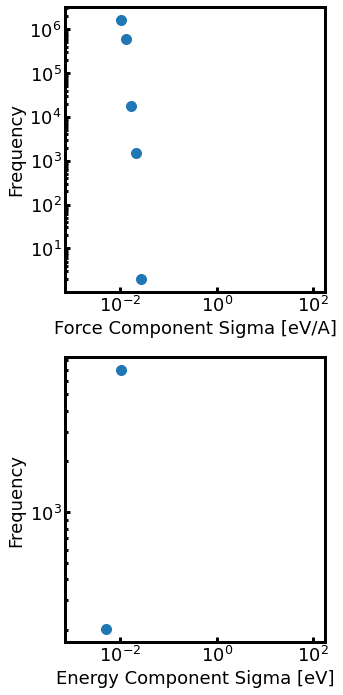

In [19]:
setup_matplotlib_environment()
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(5,10))

all_force_sigmas = []
all_energy_sigmas = []

for frame in splitter.all_structs:
    force_sigmas = frame.arrays['force_component_sigma'].flatten()
    all_force_sigmas.extend(force_sigmas)
    
    energy_sigma = frame.info['energy_sigma']
    all_energy_sigmas.append(energy_sigma)
    
all_force_sigmas = np.array(all_force_sigmas)
f_hist, f_edges = np.histogram(all_force_sigmas, bins=np.logspace(np.log10(0.001),np.log10(100.0)))
e_hist, e_edges = np.histogram(all_energy_sigmas, bins=np.logspace(np.log10(0.001),np.log10(100.0)))

ax[0].plot(f_edges[1:], f_hist, marker='o', linestyle='None')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Force Component Sigma [eV/A]")

ax[1].plot(e_edges[1:], e_hist, marker='o', linestyle='None')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Energy Component Sigma [eV]")

plt.tight_layout()

plt.savefig(os.path.join(output_dir, "Sigmas.png"))